In [4]:
from pathlib import Path
import random
import shutil
from tqdm import tqdm

class VideoSubsetCreator:
    def __init__(self, source_root: Path, target_root: Path, sample_size: int = 100):
        """
        :param source_root: Path to the folder containing 
                            DFD_original_sequences and DFD_manipulated_sequences
        :param target_root: Path where 'subset' will be created
        :param sample_size: Number of videos to sample from each folder
        """
        self.source_root = source_root
        self.target_root = target_root
        self.sample_size = sample_size
        self.folders = ['DFD_original sequences', 'DFD_manipulated_sequences']

    def create_directories(self):
        """Create the target 'subset' directory and its two subdirectories."""
        self.target_root.mkdir(parents=True, exist_ok=True)
        for folder in self.folders:
            (self.target_root / folder).mkdir(exist_ok=True)

    def sample_and_copy(self):
        """
        For each source folder:
          - Verify it exists
          - List all files
          - Randomly pick sample_size of them
          - Copy into the matching folder under target_root with a progress bar
        """
        for folder in self.folders:
            src_dir = self.source_root / folder
            dst_dir = self.target_root / folder

            if not src_dir.exists():
                print(f"[ERROR] Source folder not found: {src_dir}")
                continue

            # Gather all files in src_dir
            videos = [p for p in src_dir.iterdir() if p.is_file()]
            n = min(self.sample_size, len(videos))
            sampled = random.sample(videos, n)

            # Copy with tqdm progress bar
            for src_path in tqdm(sampled, desc=f"Copying {folder}", unit="file"):
                dst_path = dst_dir / src_path.name
                shutil.copy2(src_path, dst_path)

    def run(self):
        """Run the full process."""
        self.create_directories()
        self.sample_and_copy()
        print('Processing Done')

if __name__ == '__main__':
    # ——— UPDATE THESE TO YOUR ACTUAL PATHS ———
    # On Windows you might have something like:
    source = Path(r"C:/Users/mohit/Desktop/PROJECTS/AI_VIDEO_DETECTION")
    target = Path(r"C:/Users/mohit/Desktop/PROJECTS/AI_VIDEO_DETECTION/subset")

    creator = VideoSubsetCreator(source, target, sample_size=100)
    creator.run()

Copying DFD_original sequences:   0%|          | 0/100 [00:00<?, ?file/s]

Copying DFD_manipulated_sequences: 100%|██████████| 100/100 [00:02<00:00, 49.22file/s]

Processing Done


Using cache found in C:\Users\mohit/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\mohit\Desktop\PROJECTS\AI Image Detection\resnet-50\resnet_env_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mohit\Desktop\PROJECTS\AI Image Detection\resnet-50\resnet_env_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


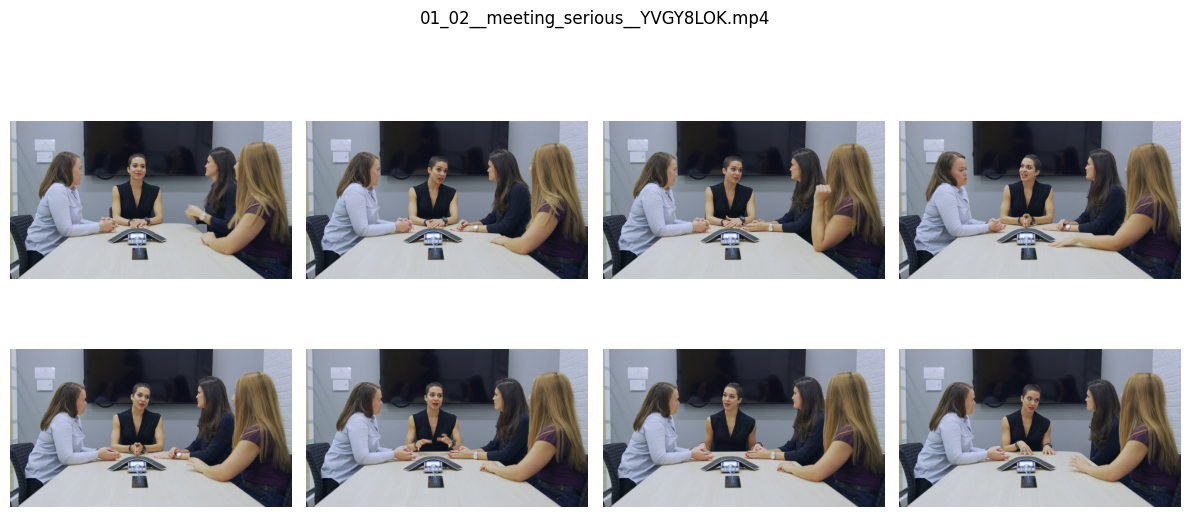

→ Verdict: FAKE
→ Fake‐probability score: 0.9930
Conclusion: This video is likely AI‐generated.


In [1]:
# Cell — Single‐Cell Inference for MobileNet

import os
import cv2
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# 1) Define the same model architecture
class MobileNetVideo(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        backbone = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
        in_f = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_f, num_classes)
        )
    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

# 2) Setup device and transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# 3) Load the saved checkpoint
checkpoint = torch.load("MobileNet._checkpoints/best_model.pth", map_location=device)
model = MobileNetVideo(num_classes=2).to(device)
model.load_state_dict(checkpoint["model_state"])
model.eval()

# 4) Inference & preview function
def infer_and_preview(video_path, model, transform, device, n_samples=8):
    # read total frames
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    if total <= 0:
        raise RuntimeError("No frames found")
    # pick evenly spaced indices
    idxs = [int(x) for x in torch.linspace(0, total-1, steps=n_samples).tolist()]
    # collect frames
    frames = []
    cap = cv2.VideoCapture(video_path)
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ok, frm = cap.read()
        if not ok: continue
        frames.append(cv2.cvtColor(frm, cv2.COLOR_BGR2RGB))
    cap.release()
    # preview grid
    cols = min(4, len(frames)); rows = (len(frames)+cols-1)//cols
    plt.figure(figsize=(cols*3, rows*3))
    for j, f in enumerate(frames):
        plt.subplot(rows, cols, j+1)
        plt.imshow(f); plt.axis('off')
    plt.suptitle(os.path.basename(video_path)); plt.tight_layout()
    plt.show()
    # prepare batch
    imgs = []
    for f in frames:
        img = Image.fromarray(f)
        imgs.append(transform(img).unsqueeze(0))
    batch = torch.cat(imgs,0).to(device)
    # forward & average
    with torch.no_grad():
        logits = model(batch)
        probs = torch.softmax(logits, dim=1)[:,1]  # P(fake)
    score = probs.mean().item()
    verdict = "FAKE" if score>0.5 else "REAL"
    # display result
    print(f"→ Verdict: {verdict}")
    print(f"→ Fake‐probability score: {score:.4f}")
    if verdict=="FAKE":
        print("Conclusion: This video is likely AI‐generated.")
    else:
        print("Conclusion: This video is likely real.")

# 5) Run inference on your sample video
video_path = "../subset/DFD_manipulated_sequences/01_02__meeting_serious__YVGY8LOK.mp4"  # ← update path
infer_and_preview(video_path, model, transform, device)
